# Introduction to Deep Learning

In this subject and the next one, we will learn about deep learning which is a type of machine learning. In this unit, we will start by discussing the basic vocabulary for deep learning such as neural network, artificial neurons, network architecture and learn about the recent role of GPUs in training these deep learning models.

### Deep learning

Let's start by defining what a neural network is. Neural networks are machine learning models that have a graph structure inspired by the brain with interconnected units called artificial neurons. There are many different types of neural network architecture. You can take a look at this video which shows different architectures trained to recognize digits from the MNIST database. https://www.youtube.com/watch?v=3JQ3hYko51Y


These networks typically have a large number of neurons and interconnections which makes them computationally expensive to train and use. However, due to recent advances in parallel computing, it's now possible to train them a lot faster using graphical processing units (GPUs), designed initially to render intensive graphical tasks like video games. **Also, we can now build larger and in particular deeper networks that can perform more complex tasks than traditional machine learning methods**. Deep learning refers to these recent deep architectures of neural networks.

### Why GPUs

Deep learning models are usually organized into successive layers of neurons. The output of each layer is fed into the next one and so on which creates **a chain of hidden layers** between the input and the network output. With this type of architecture, the network learns simple features in the first layers that are then combined into more complex ones in the next layers and so on. For instance, if the task is to build a network that recognizes faces, the first layers will detect simple features like lines and curves, and the next ones will try to combine them into more complex objects and higher-level concepts like eyes, nose, mouth and so on.

This ability to automatically **learn features from raw input makes them particularly powerful but also slower to train since each layer adds new parameters to train**. For instance, the AlexNet network, which is famous for being the first deep learning model to beat more traditional approaches in the ImageNet challenge in 2012 (http://www.image-net.org/challenges/LSVRC/2012/results.html), had a total of 650 thousand neurons and 60 million parameters. To train the model, the authors were able to parallelize repetitive operations (matrix and vector operations) using two GPUs.

### Summary

Let's summarize. Deep learning is a type of machine learning model. Deep learning models can typically solve more complex tasks but at the cost of having a larger number of parameters to tune. However, it's usually possible to accelerate the training process using the parallel computations capabilities of GPUs.

In the next units,**we will see how to create, train and use neural networks with the TensorFlow library**. In this subject, we will start by implementing the neural network equivalent to a linear regression and then the one equivalent to logistic regression. We will use our network to classify images from the MNIST database. In the next subject, we will then add layers to our networks and try to classify images from the CIFAR-10 data set. Finally, we will learn about convolutional neural networks (CNN) and test a simple one with a few layers

# Setting up TensorFlow

In this course, we will use TensorFlow (TF) to build and train our deep learning models. Deep learning is a fast-growing area of machine learning. One of the advantages of using TensorFlow is that it's developed, maintained and used internally by Google which means that it's also frequently updated with the latest models and improvements. It's also very popular. Hence, you can easily find support online.

### Different APIs

There are several ways to develop neural networks in TensorFlow

>- Via the low-level graph API
>- High-level Keras API

In the next units, we will start by introducing computation graphs which is an important underlying principle behind TensorFlow and show how to use the low-level graph API to design simple neural networks.

Later in the course, we will also learn about the Keras API which simplifies a lot of the network design and training process.

# Computation graphs

The goal of this unit is to get familiar with the TensorFlow library and the idea of computation graphs. We will take the brain and body weights data that we saw in the previous course and use TensorFlow to create, fit and use a linear regression model. This will give us a good overview of the library and the tools needed to build neural networks.

You can download the data set from the resource section.

### Brain and body weights

In [1]:
import pandas as pd

# Load data
data_df = pd.read_csv('brain-body-weights.csv')

# First five rows
data_df.head()

body  brain                     mammal
0   1.6   -2.0  Lesser short-tailed shrew
1   2.3   -1.4           Little brown bat
2   3.1   -1.2              Big brown bat
3   3.1   -0.9                      Mouse
4   3.9   -1.1                 Musk shrew

We saw in the previous course that there is a linear relationship between the **logarithm of the brain and body weights.** For this reason, the brain and body columns in the DataFrame from above contain the logarithm of the original weights. Let's plot the data.

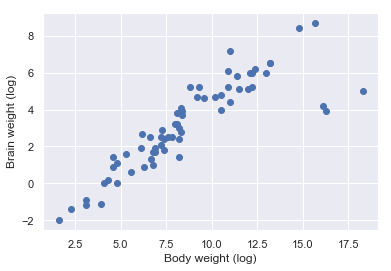

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Activate Seaborn
sns.set()

# Plot data
plt.scatter(data_df.body, data_df.brain)
plt.xlabel('Body weight (log)')
plt.ylabel('Brain weight (log)')
plt.show()

We can see in the plot that there are three clear outliers. For this example, we will keep them in the data and train our network using Huber loss.

### TensorFlow computation graphs

In TensorFlow, we define our model using **computation graphs** that specify how the different elements in our model interact with each other. In our example, we want to implement a linear regression model.

> ^y=ax+b

In this equation, a and b are the slope and intercept parameters, x is the input data and ^y the predictions that we will then use to compare to the output data y using Huber loss. We can represent our model as a sequence of computation steps that modify the data.

In [3]:
from IPython.display import Image
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2781/computation-graph.svg')

Each node in this graph is a step in our computation. For instance, the * node multiplies the input data x by a, or the loss node compares the target values y and the predictions ^y using Huber loss. This is the idea behind computation graphs. We first define a graph and then feed data that "flows" through the graph. In the TensorFlow jargon, data values are called **tensors**.

Let's see how to define our linear regression graph from above with TensorFlow.

### Variables



In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
session = tf.Session()

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We can now create the 
a
 and 
b
 parameters with the Variable object.

In [5]:
# Slope and intercept parameters
a = tf.Variable(initial_value=0, dtype=tf.float32)
b = tf.Variable(initial_value=0, dtype=tf.float32)

We need to **specify an initial value**. In our case, we can initialize the two parameters to zero. **TensorFlow assigns a data type** to each variable (and to every tensor in general). By default, it's the data type of the initial value. In our case, 0 is an integer value but both variables should be floating point numbers. Hence, we need to specify the data type by setting dtype=tf.float32.

### Placeholders

Now that we have a node for each parameter, let's create the nodes for the input and output variables. Again, the idea behind computation graphs is to start by defining a graph of operations and then run the graph by injecting data. For this reason, instead of "connecting" the graph to our data_df variable from above, we create placeholder nodes that represent the data to be fed. **We can create them with the placeholder() function.**

In [6]:
# Create a placeholder for input/target data
x = tf.placeholder(dtype=tf.float32)
y = tf.placeholder(dtype=tf.float32)

In [7]:
# Compute predictions
y_hat = a*x + b

### Loss function
Let's define the loss function. TensorFlow provides a set of operations similar to Numpy to work with tensors. For instance, we can define the mean squared error (MSE) using the square() and reduce_mean() functions.

In [8]:
# Mean squared error (MSE)
loss = tf.reduce_mean( # Equivalent to np.mean()
    tf.square( # Equivalent to np.square()
        y - y_hat # Implements broadcasting like Numpy
    )
)

Note that TensorFlow implements a few loss functions in its losses module. You can take a look at this page to see the different possibilities. https://www.tensorflow.org/api_docs/python/tf/losses

For instance, we will use the Huber loss one for our network.

In [9]:
# Huber loss
loss = tf.losses.huber_loss(y, y_hat, delta=1.0)

### Optimizer

To train our model, we need to define an optimizer. You can take a look at this page which lists the different optimizers available in TensorFlow. https://www.tensorflow.org/api_docs/python/tf/train

Let's use the simple gradient descent strategy.

In [10]:
# Create the optimizer
gd = tf.train.GradientDescentOptimizer(
    learning_rate=0.1)

In this code, we create a GradientDescentOptimizer and set its learning rate to 0.1. Note that we can also use a placeholder for the learning rate.

In [11]:
# Learning rate placeholder
lr = tf.placeholder(dtype=tf.float32)

# Create the optimizer
gd = tf.train.GradientDescentOptimizer(
    learning_rate=lr)

In this case, we will need to provide a learning rate value when "running" the graph.

Once we have the optimizer, we can add a new node to our graph that computes the gradients and applies them to the variables. We create this training operation node by calling the minimize() function with the **tensor that we want to minimize**. In our case this tensor is the loss term.

In [12]:
# Create a training operation
train_op = gd.minimize(loss)

### TensorFlow sessions

We can now evaluate the nodes in our graph and get their values using a **sessio**n. A session is a TensorFlow object that encapsulates the environment in which all tfoperations are executed and tensors are evaluated. We usually manage the resources in our session using a *with* statement

In [13]:
# Initialization operation
initialization_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Evaluate node "a"
    result = sess.run(a)
    print(result)
    # Prints: 0.0

0.0


In this code, we create a new Session object in a with statement and use it to evaluate the slope a
with its run() function. Note that we need to create and run an **initialization operation** before using the session. We can get this special operation with the global_variables_initializer() function. We won't go into the details of variable initialization for now, but you can take a look at this guide if you want to learn more about it.

### Feed data

In the example from above, we can evaluate the value of node a because it doesn't depend on any placeholder. For instance, we would get an error if we try to evaluate ^y without setting x.


**If you get this kind of error, make sure that all relevant placeholders are set and fed into the tf.Session.** To inject data into the x and y placeholders, we can use the feed_dict argument of the run() function which expects a dictionary of (tensor, values) pairs.

In [14]:
with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Compute predictions
    result = sess.run(y_hat, feed_dict={
        x: data_df.body # Feed body weights
    })
    print(result)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In this code, we inject the body weights data_df.body into the x placeholder and evaluate the y_hat node. The values that we get back from sess.run() are the values of y_hat after executing the TensorFlow Graph. In this case, we store those values in a variable called result. We get only zero values because we initialized the a and b variables to zero.

### Training

To learn the a and b parameters, we need to run the training operation node train_op. The operation depends on the x, y and the lr placeholders.

In [15]:
with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Run the training operation, get loss value
    result = sess.run([train_op, loss], feed_dict={
        x: data_df.body, # Body weights
        y: data_df.brain, # Brain weights
        lr: 0.1 # Learning rate
    })
    print(result)

[None, 2.920231]


This time, we pass a list of operations (train_op is the gradient descent) and tensors (loss is the loss value) to the run() function. Operations will only return a None value, while tensors will return their value after the graph was executed. The operation train_op will therefore give back None as a value, while the loss node will return 2.9202311, which is the loss value after running the training operation.

Let's see if these loss values decrease after each training operation by running train_op a hundred times.

In [16]:
# Monitor the a/b and loss values
loss_values = []
a_values = []
b_values = []

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Run 100 times the training operation
    for _ in range(100):
        # Run training op and collect a/b and loss values
        _, loss_val, a_val, b_val = sess.run(
            [train_op, loss, a, b],
            feed_dict={
                x: data_df.body, # Body weight
                y: data_df.brain, # Brain weight
                lr: 0.1 # Learning rate
        })

        # Save values
        loss_values.append(loss_val)
        a_values.append(a_val)
        b_values.append(b_val)

In this code, we run train_op a hundred times using a for loop that iterates over the list of digits between 0 and 99 generated with the range() function. At each iteration, we save the loss and parameter values into the loss_values, a_values and b_values lists. Note that we use the "throwaway" variable _ to discard unused results.

Let's plot the loss and parameter values.

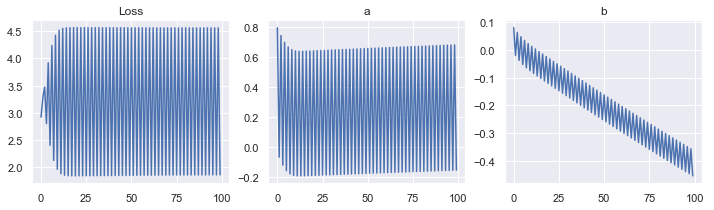

In [17]:
# Create figure with a subplot for each list of values
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(12, 3))

# Plot loss values
ax1.set_title('Loss')
ax1.plot(loss_values)

# Plot slope values
ax2.set_title('a')
ax2.plot(a_values)

# Plot intercept values
ax3.set_title('b')
ax3.plot(b_values)

plt.show()

As we can see, the loss value oscillates between 4.5 and 2 which means that gradient descent is having issues learning the a and b values.

We saw in the last course that the algorithm is sensitive to the scale of the input data. Let's try to **standardize the body weights**. Instead of modifying our data, let's add a standardization operation in our graph that standardizes the values in x using the mean and standard deviation statistics of the body weights in data_df.

In [18]:
import numpy as np

# Compute mean and std of input variable
print('Mean:', np.mean(data_df.body)) 
print('Std:', np.std(data_df.body))

Mean: 8.643076923076922
Std: 3.538620732204927


We can now add an x_standardized node using these two statistics.

In [19]:
# Standardized input x
x_standardized = (x - 8.643) / 3.539

# Redefine graph (code from above)
# ----------------
# Compute predictions
y_hat = a*x_standardized + b

# Huber loss
loss = tf.losses.huber_loss(y, y_hat)

# Learning rate placeholder
lr = tf.placeholder(dtype=tf.float32)

# Create the optimizer
gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

# Create a training operation
train_op = gd.minimize(loss)

It's important to understand that x_standardized is a new node in our computation graph. Hence, we need to "rewire" the entire graph and create all the other nodes again.

Let's rerun gradient descent with the code from above:

In [20]:
# Monitor the a/b and loss values
loss_values = []
a_values = []
b_values = []

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Run 100 times the training operation
    for _ in range(100):
        # Run training op and collect a/b and loss values
        _, loss_val, a_val, b_val = sess.run(
            [train_op, loss, a, b],
            feed_dict={
                x: data_df.body, # Body weight
                y: data_df.brain, # Brain weight
                lr: 0.1 # Learning rate
        })

        # Save values
        loss_values.append(loss_val)
        a_values.append(a_val)
        b_values.append(b_val)

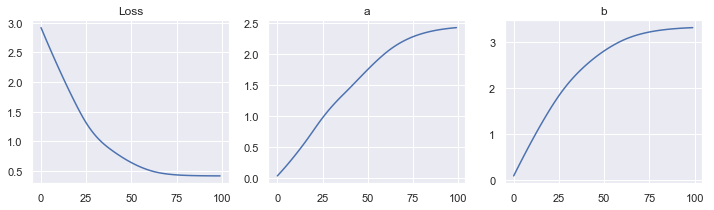

In [21]:
# Create figure with a subplot for each list of values
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(12, 3))

# Plot loss values
ax1.set_title('Loss')
ax1.plot(loss_values)

# Plot slope values
ax2.set_title('a')
ax2.plot(a_values)

# Plot intercept values
ax3.set_title('b')
ax3.plot(b_values)

plt.show()

This time, the loss value keeps decreasing after each iteration and the 
a
 and 
b
 parameters seem to stabilize after a hundred iterations.
 
### Prediction
Finally, let's see how to use our network to predict brain weights. We will compute the predictions for a hundred sample body weights between the minimum and the maximum body weight values.

In [22]:
import numpy as np

# Create a hundred sample body weights
x_values = np.linspace(
    data_df.body.min(), # Between the minimum
    data_df.body.max(), # and maximum body weight values
    num=100
)

We can now inject this sample input data into our graph. Since we use a with statement to create the session, TensorFlow automatically releases the resources and forgets the value of the a and b variables, once the code was executed. This means the optimized a and b values from the previous session above are only stored in the last position of our a_values and b_valueslist. Using the feed_dict, we can set these values and use them as tensor values in our graph.

In [23]:
with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Compute predictions
    y_values = sess.run(y_hat, feed_dict={
        x: x_values, # Sample body weights
        a: a_values[-1], # last slope value
        b: b_values[-1] # last intercept value
    })

We pass the last slope and intercept values from the a_values and b_values lists and save the predictions in a y_values variable. Note that we don't need to provide a learning rate value lr since we are not running the training operation train_op.

Let's plot the predictions with Seaborn.

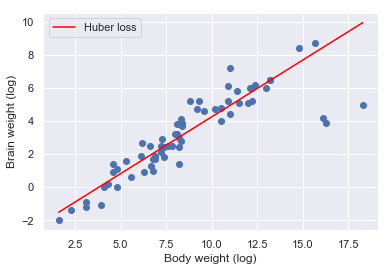

In [24]:
# Get a few colors from default color palette
blue, green, red = sns.color_palette()[:3]

# Plot data with sample predictions
plt.scatter(data_df.body, data_df.brain, label=None)
plt.plot(x_values, y_values, label='Huber loss', color='red')
plt.xlabel('Body weight (log)')
plt.ylabel('Brain weight (log)')
plt.legend()
plt.show()

We plot the data points from the data_df DataFrame and the predictions from the x_values and y_values variables.

Thanks to Huber loss, our linear regression ignores the three outliers and the line fits well the data points.

### Summary
In this unit, we learned about computation graphs and saw the basic tools to create and evaluate them with TensorFlow.

In the next unit, we will use these tools to implement a softmax regression network and train it to recognize images from the MNIST database.


Q&A : 
 The computation graph in TensorFlow 1 requires that you define all the computations/operations between the tensors (i.e. between the variables in TensorFlow which are of types tf.Variable or tf.placeholders). In our case, x and y are placeholder tensors that we will be fed in with data once the session is executed. Tensor is a special type of data that is similar to Numpy ndarray but does not necessarily work on built-in functions that expect Numpy arrays. For example, sklearn.preprocessing.scale expects an array, matrix, or list. Such a function does not work with TensorFlow tensors. That is why we need to manually define the operations such as
x_standardized = (x - 8.643) / 3.539
or
ax + b. (or tf.add(tf.multiply(a, x), b))

# Neural networks

In the previous unit, we learned about computation graphs and saw the basic TensorFlow tools to build and evaluate them. In this unit, we will implement a simple neural network to classify images from the MNIST data set. We will work on a subset of 6,000 images. You can download the data from the resource section.

### Network of neurons

We saw in the unit about deep learning that neural networks are made of artificial neurons interconnected in a network which is sometimes organized in layers. Let's take a simple example.

We usually represent neural networks with graph diagrams where nodes correspond to neurons and edges to connections between them. Here is the diagram of a simple network with three input neurons denoted 
x
1
, 
x
2
 and 
x
3
 connected to a single output neuron 
z
1
. In this notation, Neurons that are vertically aligned belong to the same layer.

In [25]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2777/three-inputs.svg')

The sensitivity of the output neuron 
z
1
 to each input neuron 
x
1
, 
x
2
 and 
x
3
 varies and evolves during the learning process. This phenomenon is called the **synaptic plasticity** in reference to the synapses in our brains which are structures that let neurons pass electrical signals to other neurons. In neural networks, we model this capability of learning and adapting the strength of the connections between neurons by assigning a **synaptic weight** to each connection. In our diagram, there are only three connections with weights 
w
1
, 
w
2
 and 
w
3
. In practice, we also add a bias parameter 
b
 to each neuron, except for the input neurons. This allows us to shift the output of the activation function.

In the network from above, each input neuron passes a signal to the output neuron. The value of the output neuron is computed by multiplying the signal of its input neurons with the synaptic weights and by adding the neuron bias.

z
1
=
w
1
x
1
+
w
2
x
2
+
w
3
x
3
+
b
1

We will learn more about biases and activation functions in later units. Note for now that this network architecture corresponds to **a linear regression.** This means that the activation function of 
z
1
 is a linear function, and the computed output 
1
 (activation without bias) stays 
1
. If we would take the output 
1
 and apply a sigmoid function to it, the outcome would become 
0.731
. In this case the network architecture would correspond to a **logistic regression.**

Let's modify the network for our MNIST classification task. The idea is to have one output neuron for each class, i.e. for each digit from 0 to 9.

In [26]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2776/mnist-input.svg')

In this network, each input neuron corresponds to one of the 784 pixels in the 28 by 28 MNIST images grid and each output neuron to a target value (the ten digits). To compute the value of an output neuron, we need to multiply the signal transmitted by the input neurons (the pixel values) by the synaptic weights of this output neuron and add its bias. In other words, each output neuron corresponds to a linear regression.

The output of those ten linear regressions can be any number. But if we want to restrict them in such a way that all ten outputs lay between 0 and 1 and that **they add up together to 1, we can apply softmax function.** This softmax function is applied to the last output layer and transforms the output from the linear regression in probabilities (so called logits). These ten logits show for each digit the probability that a given input image is the respective digit. **In such a case, the network architecture would correspond to a softmax regression.**

### Inputs and weights matrices

In practice, we don't create the network from above by connecting each neuron individually. Instead, we create a weight matrix 
W
 that contains the synaptic weights and a bias vector 
⃗
b
 with the biases.
 
$$
W=\left(\begin{array}{cccc}
w_{1,1} & w_{1,2} & \ldots & w_{1,10}\\
w_{2,1} & w_{2,2} & \ldots & w_{2,10}\\
\vdots &  &  & \vdots\\
w_{784,1} & w_{784,2} & \ldots & w_{784,10}
\end{array}\right)\qquad \vec{b}=\left(\begin{array}{c}
b_{1}\\
b_{2}\\
\vdots\\
b_{10}
\end{array}\right)
$$

Each line in 
W
 corresponds to an input neuron and each column to an output one. Hence, the 
w
i
,
j
 element is the synaptic weight between the i-th input neuron the j-th output one. The idea is to use this matrix to compute the output values for 
n
 data points, contained in an input matrix 
X
, at once.
$$
X=\left(\begin{array}{cccc}
x_{1,1} & x_{1,2} & \ldots & x_{1,784}\\
x_{2,1} & x_{2,2} & \ldots & x_{2,784}\\
\vdots &  &  & \vdots\\
x_{n,1} & x_{n,2} & \ldots & x_{n,784}
\end{array}\right)
$$

For each data point (line in 
X
), we want to compute the output of each one of the ten output neurons (columns in 
W
). To achieve this, we simply multiply the input matrix 
X
 by the weights matrix 
W
 and add the biases in 
⃗
b
.

$$
Z=XW+\vec{b}
$$

In this equation, 
Z
 is a matrix with ten values (the logits) for each data point. Let's verify that the shape of the matrices matches.

- The shape of the input matrix 
X
 is 
(
n
,
784
)
- The shape of the weights matrix 
W
 is 
(
784
,
10
)
- The shape of the biases vector 
⃗
b
 is 
(
10
,
)

Hence, the shape of the result of the matrix multiplication 
X
W
 is 
(
n
,
10
)
 and we add the biases vector using broadcasting, i.e., add the ten biases to each row. As a result we obtain a matrix 
Z
 with shape 
(
n
,
10
)
 where rows contain the ten logits for each data point. We get the final probabilities by applying the softmax function to each row of the logits matrix 
Z
.

Let's see how to implement this softmax network with TensorFlow.

### Loading MNIST data

First, let's start by loading the images and labels from the mnist-6k.npz file into an mnist dictionary.

In [27]:
import numpy as np

# Load data
with np.load('mnist-6k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

mnist


{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'labels': array([5, 0, 4, ..., 8, 6, 9])}

The dictionary contains a data entry with the pixel values of the 6,000 images and a labels one with their target values.

We will train our model on 5,000 train images, monitor the training process with a validation set of 500 images and use the 500 remaining ones to get a final test score.

In [28]:
from sklearn.model_selection import train_test_split

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32),
    mnist['labels'],
    test_size=1000, random_state=0
)

# Split again into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    test_size=500, random_state=0
)

print('Train:', X_train.shape, y_train.shape)
# Prints: (5000, 784) (5000,)
print('Validation:', X_valid.shape, y_valid.shape)
# Prints: (500, 784) (500,)
print('Test:', X_test.shape, y_test.shape)
# Prints: (500, 784) (500,)

Train: (5000, 784) (5000,)
Validation: (500, 784) (500,)
Test: (500, 784) (500,)


We split the data into train, validation and test sets by calling the train_test_split() function twice. The first time to extract a train set and the second time to separate the remaining images into validation and test sets. Note that we convert the pixel values to floating point numbers with the astype() function. That way, we won't get warnings if we need to standardize X_train, X_valid or X_test later.

### Softmax network
Let's define our neural network. First, we need to create the placeholder nodes.

In [29]:
import tensorflow as tf

# Create placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
y = tf.placeholder(dtype=tf.int32, shape=[None])

In the last unit, we created the placeholders without specifying their shape. In practice, setting the shape of placeholders is optional but can help debugging the graph. In the code from above, we set the shape of 
X
 and 
y
 to respectively 
(
n
,
784
)
 and 
(
n
,
)
 where 
n
 is the number of data points. **Since we don't know in advance how many data points we will inject into our graph, we replace 
n
 by None.**

We can now create the model parameters.

In [30]:
# Create variables
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))

This code is similar to what we saw in the previous unit. We create the two variables and set their initial values with the initial_value parameter. We create a 
(
784
,
10
)
 matrix of zeros for the weights matrix using the zeros() function from TensorFlow. Similarly, we create a 
(
10
,
)
 vector of zeros for the biases vector.

We can now implement the formula from above to compute the matrix of logits 
Z
.

In [31]:
# Compute logits
logits = tf.add(tf.matmul(X, W), b)
print(logits.shape)

(?, 10)


We use the matmul() function from TensorFlow to create a matrix multiplication operation and the add() function to add the bias values. We can verify that the shape of the logits matrix is 
(
n
,
10
)
 with the shape attribute of the logits tensor.

Now that we have a logits node that contains the predictions, let's add a loss function node to evaluate them.

### Cross-entropy loss function

We saw in the unit about logistic regressions that the loss function for logistic and softmax regressions is cross-entropy. TensorFlow implements a softmax_cross_entropy_with_logits() function that combines the softmax and cross-entropy operations. The function takes a matrix of logits and the target values and computes the cross-entropy score.

In [32]:
# Cross-entropy loss function
y_one_hot = tf.one_hot(indices=y, depth=10)
ce = tf.nn.softmax_cross_entropy_with_logits(
    labels=y_one_hot, # Requires one-hot encoded labels
    logits=logits
)
print(ce.shape)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

(?,)


**The function requires the target values to be one-hot encoded.** To achieve this, we add a one-hot encoding operation with the one_hot() function. We pass the target node y with the indices argument and the number of classes with the depth one. We can then create the softmax with cross-entropy node ce which contains the cross-entropy score for each data point.

Note that TensorFlow also provides a **sparse_softmax_cross_entropy_with_logits() function that doesn't require the labels to be one-hot encoded**

In [33]:
# Cross-entropy loss function (without one-hot encoding)
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)
print(ce.shape) # prints: (?,)

(?,)


In [34]:
# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)
print(mean_ce.shape)

()


Note that the ce and mean_ce tensors have a different shape. In the first case, the shape of ce is (?,) which means that it's a vector (1d tensor) with an unknown length. In the second case, the shape of mean_ce is () which means that it's a single value (0d tensor).

### Optimizer

Finally, let's define the optimizer and the training operation using the code from the previous unit

In [35]:
# Gradient descent
lr = tf.placeholder(dtype=tf.float32, shape=[])
gd = tf.train.GradientDescentOptimizer(
    learning_rate=lr)

# Minimize cross-entropy
train_op = gd.minimize(mean_ce)

This time, we specify the shape of the learning rate lr placeholder. Since it's a single value, we set shape=[].

### Measuring accuracy

In this example, we will also compute the accuracy of our predictions. We saw in the unit about logistic regressions that the softmax function assigns the highest probability to the class with the largest logit. To compute the accuracy of our network, let's start by creating a predictions tensor with the class that has the maximum logit value using the argmax() function.

In [36]:
# Compute predictions
predictions = tf.argmax(
    logits, # shape: (n, 10)
    axis=1, # class with max logit
    output_type=tf.int32 # Same type as labels
)
print(predictions.shape)

(?,)


The function will return the index of the column (axis one) in the logits matrix with the largest value for each data point. Hence, we get a predictions tensor with one entry for each data point, and its shape is (?,).

To compute the accuracy of our network, we need to compare these predictions to the target values. For this reason, the two tensors need to have the same data type. In the code from above, we set the data type of the output of the argmax() function with the output_type argument.

Let's compare the predictions to the target values using the equal() function.

In [37]:
# Are the predictions correct?
is_correct = tf.equal(y, predictions)
print(is_correct.shape)

(?,)


The is_correct variable is a tensor with a boolean value for each data point. The accuracy of our network is simply the proportion of True entries. To compute this accuracy value, we first convert the boolean values to numerical 0/1 values with the cast() function and then compute the mean with the reduce_mean() one.

In [38]:
# Accuracy
accuracy = tf.reduce_mean(
    # Convert booleans (false/true) to 0/1 float numbers
    tf.cast(is_correct, dtype=tf.float32)
)
print(accuracy.shape)

()


> ### Side note about reduce_mean() and data types
>
> Note that the reduce_mean() function returns a tensor with the same data type as its input. Hence, if we forget to convert our boolean values to floating points 0/1, we would get a mean of zero or one.

In [39]:
with tf.Session() as sess:
    # Test reduce_mean operation with different data types
    print(sess.run(
        tf.reduce_mean(
            # Floating points 0/1 values
            [0., 0., 1., 1., 1.]
        )
    ))
    # Prints: 0.6
    print(sess.run(
        tf.reduce_mean(
            # Integer 0/1 values
            [0, 0, 1, 1, 1]
        )
    ))

0.6
0


>In this code, we pass an array of 0/1 values to a reduce_mean() operation and run it in a session. It returns 0.6 when the values are floating point numbers but zero when they are encoded as integer values.

Now that we have a graph, let's see how to train it.

### Batch generator
In the last unit, we trained the network by running **the training operation** a hundred times using the entire data set. In practice, we often need to train neural networks on large data sets, and it's usually not possible to run the graph using the entire data. In particular, we need to be careful when running our graphs using GPUs since they have smaller memories than CPUs. For this reason, we usually train neural networks by small batches of data points.

Let's create a function that iterates through our X/y arrays by small batches of data points using Python generators with the yield syntax. You can think of generators as a Python object that can be consumed by a for loop to iterate over a set of values (for more see here : https://stackoverflow.com/a/231855).

In [40]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i:i+batch_size], y[i:i+batch_size]

get_batches(X_train, y_train, 64)

<generator object get_batches at 0x000001D36BFC8F10>

In this code, we define a get_batches() function that returns batches of data points from the X and y arrays of size batch_size. To achieve this, we generate an index i that ranges between zero and the number of data points by steps of size batch_size. For instance, if we have 10 data points and the batch size is 3, the i variable will take the values 0, 3, 6 and 9. To create the current batch, we extract rows of the X/y arrays between i and i+batch_size. In our example with ten data points, the function will create four batches.

- 1st batch - points 0, 1 and 2
- 2nd batch - points 3, 4 and 5
- 3rd batch - points 6, 7 and 8
- 4th batch - point 9

In [41]:
# Use generator in a "for" loop
for X_batch, y_batch in get_batches(X_train, y_train, 64):
    print('Batch X/y:', X_batch.shape, y_batch.shape)

Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
Batch X/y: (64, 784) (64,)
B

In this code, we set the batch size to 64, and get batches of 64 data points (except for the last batch which has 8 data points).

### Training network

Let's train our network by adapting the code from the previous unit.

In [42]:
# Accuracy score after each batch of data
acc_values = []

# Initialization operation
initialization_op = tf.global_variables_initializer()


config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training and evaluate accuracy
        _, batch_acc = sess.run([train_op, accuracy], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: 0.1 # learning rate
        })
        acc_values.append(batch_acc)

    # Get weight matrix and biases
    W_fitted = W.eval()
    b_fitted = b.eval()
    # .. which is equivalent to
    W_fitted, b_fitted = sess.run([W, b])

We start by creating an initialization operation initialization_op and run it to initialize the variables in our session. We then run the train operation train_op by batches of data and save the batch accuracy values in an acc_values variable. Finally, we get the weights matrix and the biases vector with the eval() function which is another way to evaluate tensors.

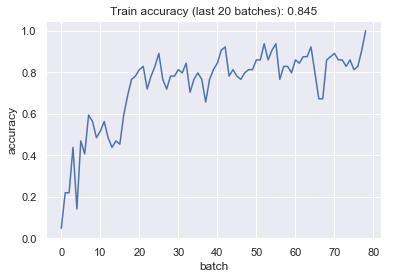

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(acc_values)
plt.title('Train accuracy (last 20 batches): {:.3f}'.format(
    # Average accuracy value
    np.mean(acc_values[-20:])
))
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

Since we evaluate the accuracy on only 64 data points, our accuracy measure is not very precise and varies a lot between each batch of data. However, it's clear that our network is learning and the final test accuracy should be between 80% and 90% if we didn't overfit.

### Visualize templates

We saw above that each output neuron learns from the data by tuning its synaptic weights (the columns of 
W
). These weights are the signature of each output neuron. They tell us what each neuron tries to detect in the input. In our case, each weight corresponds to a pixel in our 28 by 28 images. Hence, we can plot these weights to get templates of digits learned by each neuron.

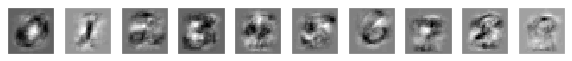

In [44]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted[:, i]

    # Reshape weight values into a 28x28 array
    template = weights.reshape(28, 28)

    # Plot array
    axis.imshow(template, plt.cm.gray_r) # Grayscale (reversed)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()

In this code, we create a figure with ten subplots using the subplots() function from Pyplot and get a list of axes. We plot each template by enumerating the axes. The axis and the i variables in the for loop contain each axis and its index in the list of axes. We use the index to extract the weights of the i-th output neuron and reshape these weights into a 28 by 28 array that we can then plot by calling the imshow() function of the axis object. Note that we hide the x and y axes with the set_visible() function

These templates define what each neuron expects. Black areas correspond to pixels that "stimulate" the output neuron, grey areas correspond to pixels that have a small impact on the output, and white areas correspond to pixels that decrease the activity of the neuron. For instance, the template for images of zeros will detect images (positive logit) with positive pixel values on the circle around the center of the image (black area) but reject ones (negative logit value) with positive pixel values in the center of the image (white area).

### Improve learning

The digits in the templates from above are not perfectly smooth. There seems to be some noise. We saw in the last course that gradient descent is sensitive to the scale of the data. Let's try to improve learning by standardizing the input data.

We can use the StandardScaler object from Scikit-learn.

In [45]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object and fit it to train data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Let's run the training process with the standardized data. **This time, we will also monitor the validation accuracy.**

In [46]:
# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Rescale input data
    X_train_rescaled = scaler.transform(X_train)
    X_valid_rescaled = scaler.transform(X_valid)

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
        # Run training and evaluate accuracy
        _, train_acc = sess.run([train_op, accuracy], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: 0.01 # decrease learning rate
        })
        train_acc_values.append(train_acc)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

    # Get weight matrix and biases
    W_fitted = W.eval()
    b_fitted = b.eval()

In this code, we rescale the train and validation data and then run the training operation in batches. At each iteration, we compute the accuracy on the current training batch and the accuracy on the validation set, and we store the values in the train_acc_values and valid_acc_values variables. Finally, we evaluate the synaptic weights and biases.

**Note that the sess.run([train_op, accuracy], ...) command for the train_acc required a dictionary input for the learning rate lr while the sess.run(accuracy, ...) command for the valid_acc didn't. This is because the accuracy tensor doesn't depend on lr, while the operater train_op does.** In other words, feed_dict needs to contain all placeholders that might be required by the tensors and operators in the run() function.

Going back to our network. Let's plot the accuracy values.

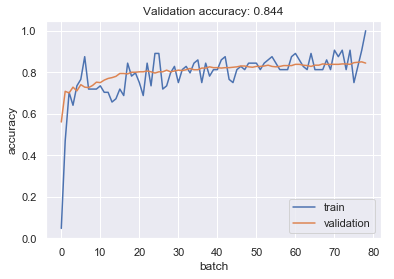

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(train_acc_values, label='train')
plt.plot(valid_acc_values, label='validation')
plt.title('Validation accuracy: {:.3f}'.format(
    valid_acc_values[-1] # Last validation accuracy value
))
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

By looking at the two curves, it doesn't seem that the model is overfitting. Both curves increase, and the last validation accuracy is around 85%.

Let's rerun the code from above to plot the values in the weights matrix W_fitted.

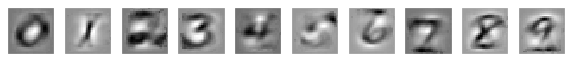

In [48]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted[:, i]

    # Reshape weight values into a 28x28 array
    template = weights.reshape(28, 28)

    # Plot array
    axis.imshow(template, plt.cm.gray_r) # Grayscale (reversed)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()

This time, the noise in the templates disappeared, and we can clearly recognize each digit.

Finally, let's compute a final accuracy measure using the test set.

In [49]:
with tf.Session() as sess:
    # Initialize the graph
    sess.run(initialization_op)

    # Compute test accuracy
    acc_val = sess.run(accuracy, feed_dict={
        X: scaler.transform(X_test), # Rescale data
        y: y_test,
        W: W_fitted, # Set weights
        b: b_fitted # Set biases
    })
    print('Test accuracy: {:.3f}'.format(acc_val))

Test accuracy: 0.850


Again, since **we create a new session, we need to initialize it by running the initialization_op and then pass the weights matrix and biases vector from above with the feed_dict argument**. Note that we also need to rescale our input test data using the scaler object from above. We get a final accuracy measure around 85%.

### Summary
In this unit, we saw how to implement a simple neural network with a single layer of neurons and saw how to train it by batches of data using a batch generator.

In the next subject, we will try to add layers of neurons to our network and learn about convolutional neural networks. But before this, let's do a short exercise to solidify our knowledge about neural networks.

### Q & A 
I dont understand why we define our neural network without the data ?
> That is the way a network is defined in TensorFlow 1. We first define a computation graph (i.e. an abstraction of all the computations without an actual input). The inputs are defined as placeholders, where we just define the shape and type. It is only at the session execution time that we feed data to these placeholders and run the graph. I agree that this is not a very pythonic way to code, but this is how the TensorFlow 1 library is defined in python.

What is the benefit of the softmax_cross_entropy() compared to the sparse one.
I compare the train accuracy curve using the two functions : I ended up with the same curve in both cases.?
>  These two loss functions used in multicalss-calssification are equivalent, but expect different format of the labels. While softmax_cross_entropy expects one-hot encoded labels y_one_hot, sparse_softmax_cross_entropy expects integer encoded labels y. Using softmax_cross_entropy with y_one_hot is exactly equivalent to using sparse_softmax_cross_entropy with y as defined in the unit. Note that passing y_one_hot to sparse_softmax_cross_entropy will throw an error. However, doing the opposite by passing y to softmax_cross_entropy might not throw an error but won’t necessarily give the expected performance results.

Why do we need to initialize in the last step? And what do we actually initialize? As we do not call train_op here I do not understand why we need to initialize and what is actually being initialized. All values that we need to evaluate the accuracy are explicitly given by the feed_dict, there are no unknowns and no default values to initialize. Same question for the y_hat evaluation at the end of the previous section. I tried both examples without sess.run(initialization_op) and do not see a difference.
>  Nice catch. You are absolutely right! In both instances, there is no need to reinitialize the variables because the variables needed in the respective operations that require initialization are already passed in the dictionary. We usually initialize the tf.Variable with the initialization operation before training. As you have noticed, the initialization here is superfluous as the variables are overwritten by the feed_dict.

### Exercise 4-7-1 and 4-7-2